# ATP Tennis Data - Other Classifiers

In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5-atp_sklearn_classifier.ipynb), we ran SVC, KNN, and RandomForest on our dataset her player stats were diffed. Our best model was Random Forest which gave us about a 85% accuracy score with a baseline of 65% accuracy for our null hypothesis if we only used player rank to predict winner and losers.

In this notebook we will run the same models (excluding SVC since it did not do well at all) using a different dataset. This data set was created in the the following [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/3-atp_basic_feature_engineering.ipynb) where we one hot encoded any categorical data that does not have any sort of ordinality - ie, tournament id, player id, surface, etc




### Results from Random Forest in previous notebook:

Random Forest Accruacy score: 0.8524918780673256

```
              precision    recall  f1-score   support

        Loss       0.82      0.90      0.86      7115
         Win       0.89      0.81      0.85      7352

    accuracy                           0.85     14467
   macro avg       0.86      0.85      0.85     14467
weighted avg       0.86      0.85      0.85     14467
```

# Summary of Results

With this dataset, we find that KNN actually out performs Random Forest with an overall accuracy score of 84.2% vs 79.4% accuracy for Random Forest using this dataset.

Previously, with the diff dataset, KNN only had an accuracy of 60% which is below our baseline of 65%



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

# files
DATASET_DIR = '../datasets'

FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff.csv'
FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff.csv'
FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff-ohe.csv'
FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe.csv'

START_YEAR = 1998
END_YEAR = 2019

MODEL_DIR = '../models'
MODEL_FILE_KNN = f'{MODEL_DIR}/knn-{START_YEAR}-{END_YEAR}-diff-ohe.pkl'
MODEL_FILE_SVC = f'{MODEL_DIR}/svc-{START_YEAR}-{END_YEAR}-diff-ohe.pkl'
MODEL_FILE_RF = f'{MODEL_DIR}/rf-{START_YEAR}-{END_YEAR}-diff-ohe.pkl'

REPORT_DIR = '../reports'
REFPORT_FILE = f'{REPORT_DIR}/report.csv'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



In [2]:
def analyze_predictions(y_test, y_predict, y_predict_proba=None):
    # TODO: add score
    
    if y_predict_proba:
        print(roc_auc_score(y_test, y_predict_proba))
    
    print(classification_report(y_test, y_predict, target_names=['Loss', 'Win']))
    cm = pd.DataFrame(confusion_matrix(y_test, y_predict), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
    print(cm)
    sns.heatmap(cm, annot=True)

In [3]:
from sklearn.preprocessing import MinMaxScaler


def plot_2d(X_test, y_predict):
    """
    Use PCA to dimensionality reduction then plot win vs loses
    :param: X_test - test features
    :param: y_predict - predictions from model
    """
    
    # normalize our data first before using PCA so weights are the same for all variables
    mms = MinMaxScaler()
    normalized_df = X_test.copy()
    for col in normalized_df.columns:
        normalized_col = mms.fit_transform([normalized_df[col].values])
        normalized_df[col] = normalized_col[-1]
    

    # reduce X to 2D
    X_test_2d = pd.DataFrame(PCA(n_components=2).fit_transform(X_test))

    # let's figure out which ones of these are predicted Wins
    wins = X_test_2d[y_predict == 1]

    # entries that are predicted losses
    losses = X_test_2d[y_predict == 0]

    f, a = plt.subplots(1, 1, figsize=(20,5))
    p = sns.scatterplot(x=0, y=1, data=losses, ax=a, color='r', alpha=0.25)
    p = sns.scatterplot(x=0, y=1, data=wins, ax=a, color='b', alpha=0.25)


# KNN

In [4]:
# extract features and labels
features = pd.read_csv(f'{FEATURE_FILE_DIFF_OHE}')
labels = features[LABEL_COL].copy()
features = features.drop([LABEL_COL], axis=1)



In [5]:

# train our model
X_train, X_test, y_train, y_test = \
        train_test_split(features, labels, random_state=RSTATE)
knn = KNeighborsClassifier(n_jobs = N_JOBS).fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)

In [6]:
knn.score(X_test, y_test)

0.8421478683216406

              precision    recall  f1-score   support

        Loss       0.83      0.86      0.84      7378
         Win       0.85      0.83      0.84      7446

    accuracy                           0.84     14824
   macro avg       0.84      0.84      0.84     14824
weighted avg       0.84      0.84      0.84     14824

      Loss   Win
Loss  6311  1067
Win   1273  6173


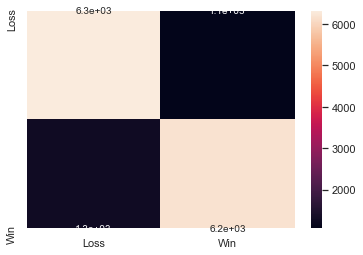

In [7]:
analyze_predictions(y_test, y_predict_knn)

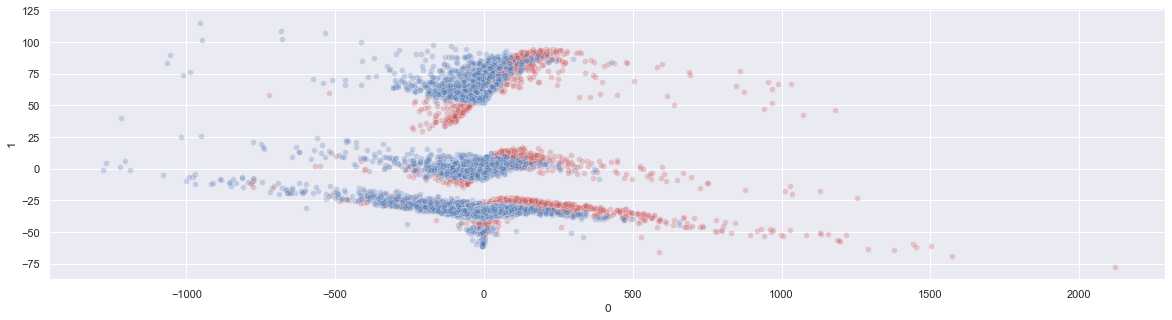

In [8]:
plot_2d(X_test, y_predict_knn)

In [9]:
pickle.dump(knn, open(MODEL_FILE_KNN, 'wb'))

# Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=RSTATE, verbose=1).fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)
rf.score(X_test, y_test)

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


0.7945223961144091

              precision    recall  f1-score   support

        Loss       0.77      0.84      0.80      7378
         Win       0.82      0.75      0.79      7446

    accuracy                           0.79     14824
   macro avg       0.80      0.79      0.79     14824
weighted avg       0.80      0.79      0.79     14824

      Loss   Win
Loss  6167  1211
Win   1835  5611


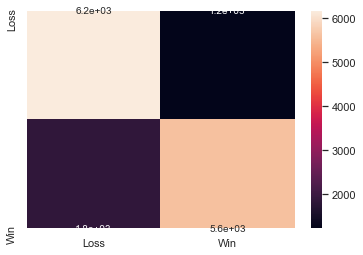

In [11]:
analyze_predictions(y_test, y_predict_rf)

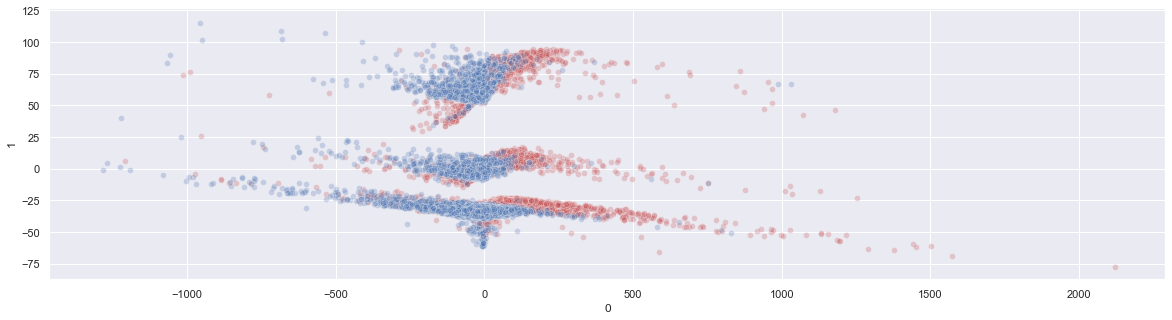

In [12]:
plot_2d(X_test, y_predict_rf)

In [13]:
pickle.dump(knn, open(MODEL_FILE_RF, 'wb'))

### Let's see if we can explain what Random Forest is Doing



In [14]:
import shap

shap.initjs()

explainer_knn = shap.TreeExplainer(knn)
shap_values_knn = explainer_rf.shap_values(X_test)

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>

In [ ]:
import shap

shap.initjs()

explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)


In [ ]:
X_test.shape

In [ ]:
shap_rf_df = pd.DataFrame(shap_values_rf[-1], columns=X_test.columns)
print(shap_rf_df.shape)
shap_rf_df.head()


In [ ]:
print('Expected Value:', explainer.expected_value)


### Let's look at some predictions that were correct and which ones were not

In [ ]:
shap.summary_plot(shap_values_rf, feature_names=X_test.columns, title="Feature Importance")

In [ ]:
correct_indexes = (y_predict_rf == y_test.tolist())
correct_indexes

### Correctly predicted entry

In [ ]:
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0][1][:], X_test.iloc[1,:], feature_names=X_test.columns)

In [ ]:
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0][2][:], X_test.iloc[2,:], feature_names=X_test.columns)

### Incorrectly predicted entry

For this entry, model predicted that p1 will lose to 2. However, the correct result should have been p1 beats p2

* You see that draw size played a much bigger role in determine the outcome
* round lable in previous entry actually helped us predict p1 will be p2 but in this one, it played a big role in predicting the wrong result


In [ ]:
y_predict_rf[0]

In [ ]:
y_test.iloc[0]

In [ ]:
X_test.iloc[0]

In [ ]:
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0][0][:], X_test.iloc[0,:], feature_names=X_test.columns)

In [ ]:
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0][:1000][:], X_test.iloc[:1000,:], feature_names=X_test.columns)


In [ ]:
shap.image_plot(shap_values_rf[0], X_test, labels=y_predict_rf)

### Partial Dependence Plots

Background:
* If player 1 is ranked higher (ie, #1) than player 2 (ie, #5), seed_diff is negative -> player 1 is expected to beat player 2
* Conversely if player 1 has lower rank than player 2, seed_diff is positive -> player 2 is expected to beat player 1


The higher the absolute value here (ie, left and right edges of graph), this indications that more the difference in rank.

As expected, if number is negative, you would tend to predict p1 as winner. If number is postive, you would predict winner is p2.

Interestly, you see that if Player 1 is a higher rank than player 2, the more the difference, this information contributes more to predicting player 1 will win. However, if player 1 is ranked lower than player 2, as the difference is more, this does not contribute as much to model predicting losses.

In [ ]:
shap.dependence_plot(ind='seed_diff', interaction_index='seed_diff',
                     shap_values=shap_values_rf[0], 
                     features=X_test,  
                     display_features=X_test)

In [ ]:
shap.dependence_plot(ind='age_diff', interaction_index='age_diff',
                     shap_values=shap_values_rf[0], 
                     features=X_test,  
                     display_features=X_test)

In [ ]:
shap.dependence_plot(ind='p1_ioc', interaction_index='p2_ioc',
                     shap_values=shap_values_rf[0], 
                     features=X_test,  
                     display_features=X_test)